In [193]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
import gc

In [200]:
#FILE
model_folder='eda/models/sample_run/'
comment='add_perc_ip_non_fraud'
model_file='model'+comment
model_save=model_folder+model_file
metrics_file='eda/metrics.csv'

In [201]:
metrics = 'auc'

In [202]:
train_feature_file='eda/features/train/all_features_valid_hr_is_test_hr.csv'
# valid_feature_file='eda/features/train/all_features.csv'
valid_feature_file='eda/features/valid/all_features_valid_hr_is_test_hr.csv'

In [203]:
train_df=pd.read_csv(train_feature_file,parse_dates=['click_date'])
val_df=pd.read_csv(valid_feature_file,parse_dates=['click_date'])
train_df=train_df.drop(['ip','click_time', 'attributed_time','click_date'],axis=1)
val_df=val_df.drop(['ip','click_time', 'attributed_time','click_date'],axis=1)

print(train_df.info())
print(val_df.info())

print("train size: ", len(train_df))
print("valid size: ", len(val_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659630 entries, 0 to 659629
Data columns (total 16 columns):
app               659630 non-null int64
device            659630 non-null int64
os                659630 non-null int64
channel           659630 non-null int64
is_attributed     659630 non-null int64
hour              659630 non-null int64
day               659630 non-null int64
minute            659630 non-null int64
perc_ip           66424 non-null float64
IN_TEST_HH        659630 non-null int64
IP_DAY_TEST_HH    659630 non-null int64
IP_DAY_HH         659630 non-null int64
IP_OS_HH          659630 non-null int64
IP_APP_HH         659630 non-null int64
IP_APP_OS_HH      659630 non-null int64
APP_DAY_HH        659630 non-null int64
dtypes: float64(1), int64(15)
memory usage: 80.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150531 entries, 0 to 150530
Data columns (total 16 columns):
app               150531 non-null int64
device            150531 non-null int64


In [208]:
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':metrics,
        'learning_rate': 0.1,
        'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
        'max_depth': 4,  # -1 means no limit
        'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'subsample': 0.7,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'nthread': 4,
        'verbose': 0,
        'scale_pos_weight':99.7, # because training data is extremely unbalanced 
        'metric':metrics
}
target = 'is_attributed'
preds=train_df.columns
col_to_remove=['is_attributed']
predictors = list(set(preds) - set(col_to_remove))
categorical = ['app', 'device', 'os', 'channel', 'hour','day']


In [209]:
VALIDATE = True
MAX_ROUNDS = 500
EARLY_STOP = 50
OPT_ROUNDS = 500
print("Training...")

num_boost_round=MAX_ROUNDS
early_stopping_rounds=EARLY_STOP

xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del train_df
gc.collect()
print('done...')

Training...


6152

done...


In [210]:
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

167

In [211]:
evals_results = {}
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgtrain, xgvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

n_estimators = bst.best_iteration
bst.save_model(model_save)
print("\nModel Report")
print("n_estimators : ", n_estimators)
print(metrics+":", evals_results['valid'][metrics][n_estimators-1])
del xgvalid

/Users/aronak/miniconda3/envs/ml_3_6/lib/python3.5/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/aronak/miniconda3/envs/ml_3_6/lib/python3.5/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[10]	train's auc: 0.963095	valid's auc: 0.945796
[20]	train's auc: 0.968258	valid's auc: 0.950343
[30]	train's auc: 0.972433	valid's auc: 0.950491
[40]	train's auc: 0.975951	valid's auc: 0.952961
[50]	train's auc: 0.978716	valid's auc: 0.953665
[60]	train's auc: 0.981619	valid's auc: 0.953521
[70]	train's auc: 0.983138	valid's auc: 0.953544
[80]	train's auc: 0.984568	valid's auc: 0.9542
[90]	train's auc: 0.986251	valid's auc: 0.954308
[100]	train's auc: 0.987298	valid's auc: 0.953613
[110]	train's auc: 0.988392	valid's auc: 0.953429
[120]	train's auc: 0.989212	valid's auc: 0.953181
[130]	train's auc: 0.990056	valid's auc: 0.952645
Early stopping, best iteration is:
[84]	train's auc: 0.98541	valid's auc: 0.954741

Model Report
n_estimators :  84
auc: 0.9547407937624217


In [212]:
def get_feature_imp(bst):
    x=dict(zip(bst.feature_name(),bst.feature_importance()))
    import operator
    sorted_x = sorted(x.items(), key=operator.itemgetter(1),reverse=True)
    return sorted_x

In [213]:
import datetime
date_time=datetime.datetime.now()
train_acc=evals_results['train']['auc'][n_estimators-1]
valid_acc=evals_results['valid']['auc'][n_estimators-1]
bst_iter=n_estimators
feature_imp=get_feature_imp(bst)
comment='Added perc IP_'+comment

In [214]:
#prepare metrics and see
col_list=['date_time','train_acc','valid_acc','best_iter','cols','model_file','feature_imp','comment','lBSCore']
curr_data=pd.DataFrame([[date_time,train_acc,valid_acc,bst_iter,predictors,model_save,feature_imp,comment,'Unknown']], columns=col_list)
curr_data.head()

,date_time,train_acc,valid_acc,best_iter,cols,model_file,feature_imp,comment,lBSCore
0,2018-04-12 21:37:01.333789,0.98541,0.954741,84,"[IP_OS_HH, perc_ip, os, IP_APP_OS_HH, IP_DAY_H...",eda/models/sample_run/modeladd_perc_ip_non_fraud,"[(channel, 180), (os, 93), (app, 86), (hour, 7...",Added perc IP_add_perc_ip_non_fraud,Unknown


In [215]:
# ADD to records
add_to_records=True
log=pd.read_csv(metrics_file)
if(add_to_records):
    log=log.append(curr_data)
    log.to_csv(metrics_file,index=False)
    print('records updated')
    log.head(5)
gc.collect()
#resetCSV
# curr_data.to_csv(metrics_file,index=False)
# curr_data.head()

records updated


,best_iter,cols,comment,date_time,feature_imp,lBSCore,model_file,train_acc,valid_acc
0,496,"['app', 'device', 'os', 'channel', 'hour', 'da...","1M, andys features,specific hours",2018-04-11 18:56:47.435974,NaN,NaN,NaN,0.997562,0.997562
1,46,"['app', 'device', 'os', 'channel', 'hour', 'da...","1M,andys features,specific hours_valid_hr_is_t...",2018-04-12 11:53:21.394388,"[('channel', 80), ('app', 73), ('os', 49), ('I...",Unknown,eda/models/sample_run/model_valid_hr_is_test_hr,0.977335,0.953036
2,46,"['app', 'device', 'os', 'channel', 'hour', 'da...","Added perc IP_Added perc IP1M,andys features,s...",2018-04-12 21:29:50.820867,"[('channel', 80), ('app', 73), ('os', 49), ('I...",Unknown,eda/models/sample_run/model_valid_hr_is_test_hr,0.977335,0.953036
0,84,"[IP_OS_HH, perc_ip, os, IP_APP_OS_HH, IP_DAY_H...",Added perc IP_add_perc_ip_non_fraud,2018-04-12 21:37:01.333789,"[(channel, 180), (os, 93), (app, 86), (hour, 7...",Unknown,eda/models/sample_run/modeladd_perc_ip_non_fraud,0.985410,0.954741


80

In [152]:
#Add LBScore
index=None
lbscore=None
if(index is not None):
    log=pd.read_csv(metrics_file)
    log.at[index, 'lBSCore'] = lbscore

In [150]:
log.iloc[1]

best_iter                                                     46
cols           ['app', 'device', 'os', 'channel', 'hour', 'da...
comment        1M,andys features,specific hours_valid_hr_is_t...
date_time                             2018-04-12 11:53:21.394388
feature_imp    [('channel', 80), ('app', 73), ('os', 49), ('I...
lBSCore                                                   0.9493
model_file       eda/models/sample_run/model_valid_hr_is_test_hr
train_acc                                               0.977335
valid_acc                                               0.953036
Name: 1, dtype: object

Plot metrics during training...1


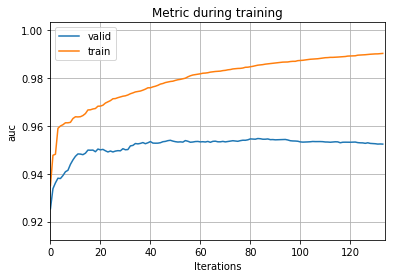

In [216]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plot_example.py.')

print('Plot metrics during training...1')
ax = lgb.plot_metric(evals_results)
plt.show()

Plot feature importances...


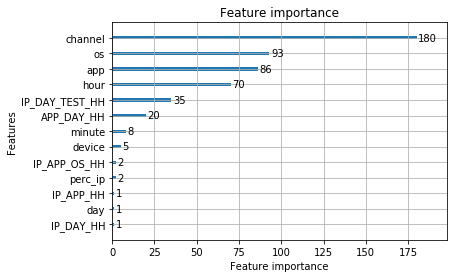

In [217]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plot_example.py.')

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=50)
plt.show()

Plot feature importances...


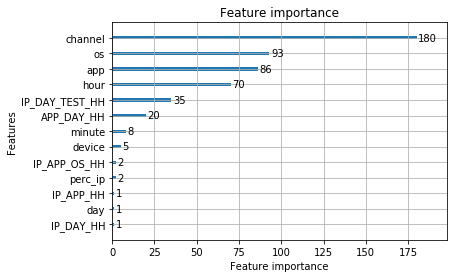

In [218]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    raise ImportError('You need to install matplotlib for plot_example.py.')

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=50)
plt.show()

In [180]:
feature_imp

[('channel', 80),
 ('app', 73),
 ('os', 49),
 ('IP_DAY_TEST_HH', 30),
 ('hour', 28),
 ('APP_DAY_HH', 14),
 ('IP_DAY_HH', 2),
 ('IP_OS_HH', 0),
 ('IP_APP_OS_HH', 0),
 ('day', 0),
 ('IP_APP_HH', 0),
 ('device', 0),
 ('IN_TEST_HH', 0)]